In [4]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
import random

In [5]:
# GLOBAL VARIABLES 
os.chdir("/home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject")
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 

base_path = "ObjectDetectedDataset/"
inputTrainPath = base_path + "train/edge_detected"
inputTestPath = base_path + "test/edge_detected" 

outputTrainPath = base_path + "train/tom_jerry_images"
outputTestPath = base_path + "test/tom_jerry_images"

trainingDirectories = [inputTrainPath, outputTrainPath]
testingDirectories = [inputTestPath, outputTestPath]

Working Directory: /home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject


In [6]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(inputDirectories, outputDirectories): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")
    else: 
        input_image = input_image.convert("RGB")
        output_image = output_image.convert("RGB")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [7]:
trainingPaths = getFilePaths([trainingDirectories[0]], [trainingDirectories[1]])
testingPaths = getFilePaths([testingDirectories[0]], [testingDirectories[1]])

maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [8]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []


# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (128, 128)
for train_input_path, train_output_path in trainingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_train.append(inputImage)
    y_train.append(outputImage)

for train_input_path, train_output_path in testingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_test.append(inputImage)
    y_test.append(outputImage)


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [9]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

983 983
368 368
(983, 128, 128)
(983, 128, 128)
(368, 128, 128)
(368, 128, 128)


In [10]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
class AutoencoderWithDense(Model):
    def __init__(self, latent_dim, dropout_rate=0.4):
        super(AutoencoderWithDense, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(personal_image_shape[1] * personal_image_shape[0], activation='sigmoid'),
            layers.Reshape((personal_image_shape[1], personal_image_shape[0])) # is reversed from other functions
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
autoencoder_with_dense = AutoencoderWithDense(latent_dim = 150)
autoencoder_with_dense.compile(optimizer='adam', 
                               loss=losses.MeanSquaredError())

autoencoder_with_dense.build(input_shape=(128,128))
print(autoencoder_with_dense.summary())
callback = EarlyStopping(monitor="val_loss", patience = 15)

history = autoencoder_with_dense.fit(train_dataset,
                epochs=250,
                shuffle=True,
                validation_data=(test_dataset), 
                callbacks=callback)

Model: "autoencoder_with_dense_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (128, 150)                2516118   
                                                                 
 sequential_5 (Sequential)   (128, 128, 128)           35824640  
                                                                 
Total params: 38340758 (146.26 MB)
Trainable params: 38340758 (146.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/250


ValueError: in user code:

    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filefhd6zt3x.py", line 10, in tf__call
        encoded = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'autoencoder_with_dense_2' (type AutoencoderWithDense).
    
    in user code:
    
        File "/tmp/ipykernel_56110/2690518326.py", line 23, in call  *
            encoded = self.encoder(x)
        File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/linus/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).
        
        Input 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (None, 16384)
        
        Call arguments received by layer 'sequential_4' (type Sequential):
          • inputs=tf.Tensor(shape=(None, 128, 128), dtype=float32)
          • training=True
          • mask=None
    
    
    Call arguments received by layer 'autoencoder_with_dense_2' (type AutoencoderWithDense):
      • x=tf.Tensor(shape=(None, 128, 128), dtype=float32)


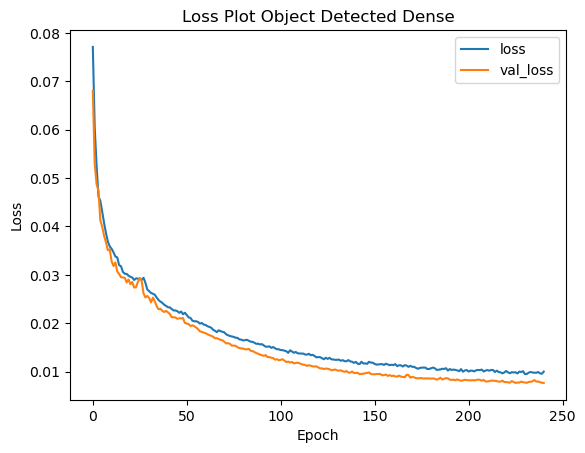

In [ ]:
# print training and value loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss Plot Object Detected Dense")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

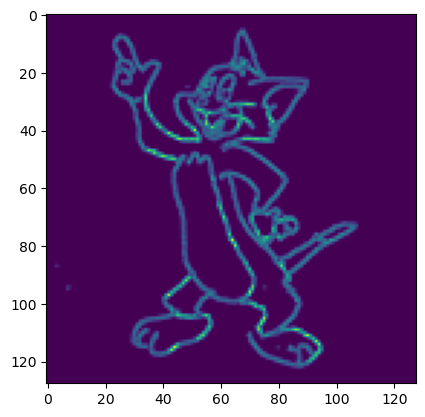

In [ ]:
# code found from: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True


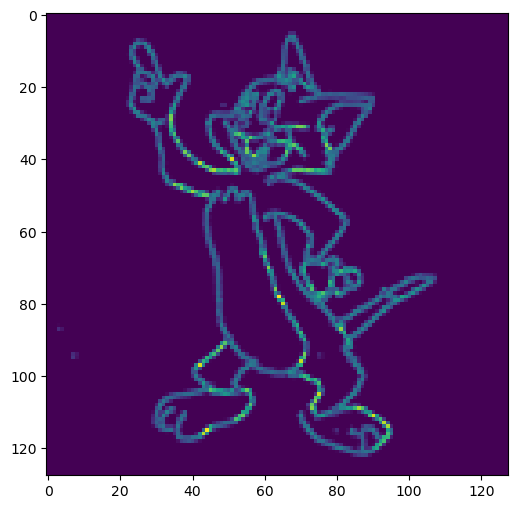

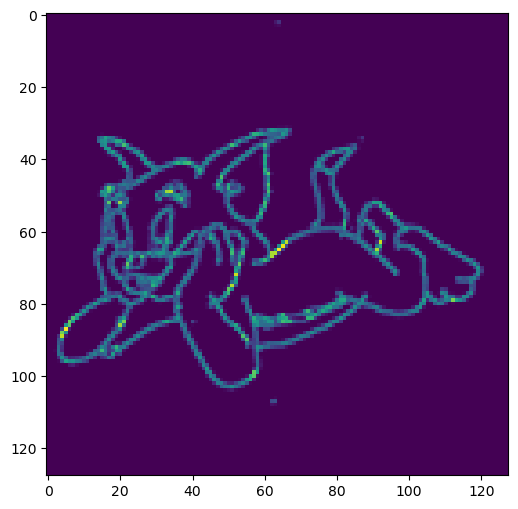

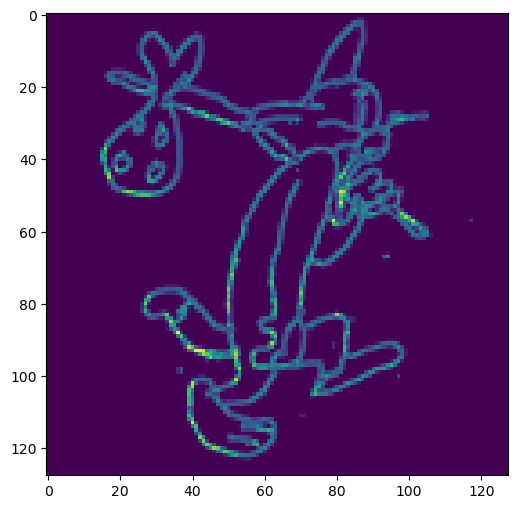

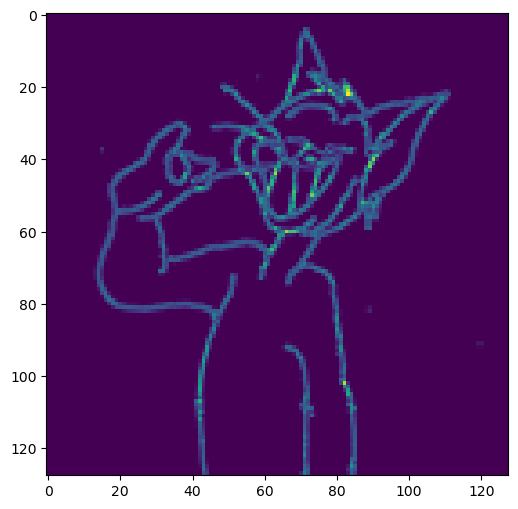

In [ ]:
imageNames = os.listdir("images_to_display/handdrawn/tom_edge_detected/")

handdrawnImages = []

for imageName in imageNames: 
    image = Image.open(f"images_to_display/handdrawn/tom_edge_detected/{imageName}")
    image = expand2square(image, (0,0,0))
    image = image.resize((128, 128))
    image = image.convert("L")
    plt.figure(figsize=(12, 6))

    plt.imshow(image)

    plt.show()
    handdrawnImages.append(np.array(image))
handdrawnImages = np.array(handdrawnImages)

In [ ]:
# Display images for testing

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = autoencoder_with_dense.predict(x_train)[trainImageIndex]
test_output_image = autoencoder_with_dense.predict(x_test)[testImageIndex]
handdrawn_image = autoencoder_with_dense.predict(handdrawnImages)[3]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

NameError: name 'random' is not defined

In [ ]:
autoencoder_with_dense.save("src/SavedModels/ObjectDetectedDense.keras")